### Hybrid Parallel Drone Classifier

In [ ]:
USING_COLAB = True
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ModuleNotFoundError:
    USING_COLAB = False

In [ ]:
import sys

if USING_COLAB is True:
    radar_path = "/content/drive/MyDrive/Radar"
else:
    radar_path = "Radar"
if radar_path not in sys.path:
    sys.path.insert(0, radar_path)
data_dir = "two_sided"
model_dir = "two_sided_models"
roc_curve_minimum = 1e-4

In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as ds
from torcheval.metrics.functional import multiclass_f1_score

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

drone_type_map = ["DJI_Matrice_300_RTK", "DJI_Mavic_Air_2",
                  "DJI_Mavic_Mini", "DJI_Phantom_4", "Parrot_Disco"]

In [ ]:
!pip install wandb
!pip install mlxtend
!pip install pennylane

In [ ]:
import pennylane as qml

# Define the quantum circuit using PennyLane
n_qubits = 5
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode0(inputs, weights):
    #print(f"qnode0: {weights=}")
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

@qml.qnode(dev)
def qnode1(inputs, weights):
    #print(f"qnode1: {weights=}")
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

@qml.qnode(dev)
def qnode2(inputs, weights):
    #print(f"qnode2: {weights=}")
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

@qml.qnode(dev)
def qnode3(inputs, weights):
    #print(f"qnode3: {weights=}")
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

# Define the QLayer
n_layers = 3
weight_shapes = {"weights": (n_layers, n_qubits)}


class HybridRadarClassifier(nn.Module):
  def __init__(self, conf):
        super(HybridRadarClassifier, self).__init__()

        # i/p shape - (batch_size, Channel_in, Height_in, Width_in) - (2, 16, 251)
        self.conv1 = nn.Conv2d(2, 16, (3,3), padding =1) # o/p shape - (16, 16, 251)
        self.IN1 = nn.InstanceNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2, padding =1) # o/p shape (16, 8, 126)
        self.conv2 = nn.Conv2d(16, 32, (5,5), padding = 2) # o/p shape (32, 8, 126)
        self.IN2 = nn.InstanceNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2) # o/p shape (32, 4, 63)

        #quantum layer
        self.qlayer1 = qml.qnn.TorchLayer(qnode0, weight_shapes)
        self.qlayer2 = qml.qnn.TorchLayer(qnode1, weight_shapes)
        self.qlayer3 = qml.qnn.TorchLayer(qnode2, weight_shapes)
        self.qlayer4 = qml.qnn.TorchLayer(qnode3, weight_shapes)

        #fully connected layers
        self.fc1 = nn.Linear( 32 * 12 * 21 , 120)
        self.fc2 = nn.Linear( 120 , 20 )
        self.fc3 = nn.Linear( 20 , 5)  # o/p shape should be (batch_size,5,1,1)

        self.drop = nn.Dropout2d(p=0.5)
        self.relu = nn.LeakyReLU()

  def forward(self, x):
        # i/p shape - (batch_size, Channel_in, Height_in, Width_in) - (2, 16, 251)
        x = self.pool1(self.relu(self.IN1(self.conv1(x))))
        x = self.drop(x)
        x = self.pool2(self.relu(self.IN2(self.conv2(x))))
        x = self.drop(x)
        #flatten
        x = x.view(-1, 32 * 12 * 21) # x = torch.flatten(x, start_dim=1
        #FC layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))

        # qlayers connected parallely
        # Make sure the values are normalised to lie in the range [0,pi]
        # since the qnodes are using angle embedding
        x = F.normalize(x) * np.pi
        x_1, x_2, x_3, x_4 = torch.split(x, 5, dim=1)
        #print(f"input {x_1=}")
        x_1 = self.qlayer1(x_1)
        x_2 = self.qlayer2(x_2)
        x_3 = self.qlayer3(x_3)
        x_4 = self.qlayer4(x_4)
        #print(f"output {x_1=}")
        x = torch.cat([x_1, x_2, x_3, x_4], axis=1)

     # if we want qlayers connected serially?
       # x = self.qlayer1(x)
       # x = self.qlayer2(x)
       # x = self.qlayer3(x)
       # x = self.qlayer4(x)

        x = self.fc3(x)
        return x


In [ ]:
import time
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import torchvision
import torch.nn.functional as F
import torchvision.datasets as ds
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay


model_path = f"{radar_path}/{model_dir}"
plot_path = f"{radar_path}/{plot_dir}"
os.system(f"mkdir -p {model_path}")
os.system(f"mkdir -p {plot_path}")


def dataloader(file_extension):
    data = np.load(file_extension)
    return data


def plot_spectrogram(sp):
    fig, axs = plt.subplots(2, ncols=1, figsize=(14,3))

    axs[0].imshow(sp[0])
    axs[1].imshow(sp[1])

    plt.tight_layout()
    plt.show()


def plot_multiclass_roc(target, probs, remove_zeros=False, semilog_axes=True):
    lb = LabelBinarizer().fit(target)
    one_hot_target = lb.transform(target)

    fig, ax = plt.subplots(figsize=(5, 5))
    colors = cycle(['#348ABD', '#b74331', '#8EBA42', '#FBC15E', '#988ED5'])
    for class_id, color in zip(range(5), colors):
        fpr, tpr, _ = roc_curve(one_hot_target[:,class_id], probs[:,class_id])
        if remove_zeros is True:
            zero_indices = np.where(np.isclose(fpr, 0))
            fpr = np.delete(fpr, zero_indices)
            tpr = np.delete(tpr, zero_indices)
        else:
            fpr[np.isclose(fpr,0)] = 1e-10
        display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(
            name=f"{drone_type_map[class_id]}",
            ax=ax,
            color=color)
    if semilog_axes is True:
        display.ax_.set_xscale("log")
        display.ax_.set_xlim(roc_curve_minimum, 1.0)
    display.ax_.set_xlabel("False Positive Rate")
    display.ax_.set_ylabel("True Positive Rate")
    line = plt.plot(np.geomspace(roc_curve_minimum,1.0), np.geomspace(roc_curve_minimum,1.0),
                    color='k', linestyle="dashed", label="Chance")
    display.ax_.legend()
    plt.tight_layout()
    plt.show()


def train(conf, trainLoader, device):

    net = HybridRadarClassifier(conf).to(device)

    optim = torch.optim.AdamW(net.parameters(), lr=conf["learning_rate"])
    criterion = nn.CrossEntropyLoss().to(device)

    for x in range(conf["epochs"]):

        net.train()

        for i, data in enumerate(trainLoader):
            # plot_spectrogram(torch.squeeze(data[0]))
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optim.zero_grad()

            outputs = net(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optim.step()
            loss_val = loss.item()

        print('Train Epoch: {} Loss: {:.6f}'.format(x, loss_val))
        if loss_val < conf['loss_threshold']:
            break

    if conf['save_model'] is True:
        print(f"Saving model state to {conf['model_path']}")
        torch.save(net.state_dict(), conf['model_path'])


def test(conf, testLoader, device):

    # load model state
    net = HybridRadarClassifier(conf).to(device)
    net.load_state_dict(torch.load(conf['model_path']))
    net.eval()

    correct = 0
    total = 0
    testloss = 0
    predicted = None
    probabilities = None
    target = None

    loss_fn = nn.CrossEntropyLoss().to(device)

    confm = np.zeros((5, 5), dtype=int)
    for i, data in enumerate(testLoader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        if target is None:
            target = labels
        else:
            target = torch.cat((target, labels))

        outputs = net(inputs.float())
        loss = loss_fn(outputs, labels)
        testloss += loss.item()

        partial_probabilities = nn.Softmax(dim=1)(outputs.data)
        if probabilities is None:
            probabilities = partial_probabilities
        else:
            probabilities = torch.cat((probabilities, partial_probabilities))

        _, partial_predicted = torch.max(outputs.data, 1)
        if predicted is None:
            predicted = partial_predicted
        else:
            predicted = torch.cat((predicted, partial_predicted))

    plot_multiclass_roc(target, probabilities)

    confm = confusion_matrix(target, predicted)
    print(f"{confm=}")
    if conf['plot_confusion'] is True:
        plt.close()
        fig, ax = plot_confusion_matrix(conf_mat=confm,
                                        show_normed=True,
                                        colorbar=True,
                                        class_names=drone_type_map)
        plt.tight_layout()
        plt.show()

    f1 = multiclass_f1_score(predicted, target, num_classes=5, average='micro')
    print(f"{f1=}")


### Debug Code

In [ ]:
conf = {}
conf['f_s'] = 10_000
conf['SNR'] = 10
conf['batch_size'] = 1
conf['epochs'] = 10
conf['learning_rate'] = 0.01

trainset_root = f"{radar_path}/{data_dir}/trainset/{conf['f_s']}fs/{conf['SNR']}SNR"
trainds = ds.DatasetFolder(
    trainset_root, dataloader, extensions=("npy",))
trainLoader = torch.utils.data.DataLoader(
    trainds, conf["batch_size"], shuffle=True, num_workers=2)

testset_root = f"{radar_path}/{data_dir}/testset/{conf['f_s']}fs/{conf['SNR']}SNR"
testds = ds.DatasetFolder(
    testset_root, dataloader, extensions=("npy",))
testLoader = torch.utils.data.DataLoader(
    testds, conf["batch_size"], shuffle=True, num_workers=2)

# By default the DatasetFolder assigns labels based on the alphabetically
# sorted list of sub-folder names. Run the following code to see the
# results.
#
# class_list, class_dict = trainds.find_classes(dataset_root_template)
# print(f"{class_list=}")
# print(f"{class_dict=}")

net = HybridRadarClassifier(conf).to(device)

optim = torch.optim.AdamW(net.parameters(), lr=conf["learning_rate"])
criterion = nn.CrossEntropyLoss().to(device)

net.train()

for i, data in enumerate(trainLoader):
    # plot_spectrogram(torch.squeeze(data[0]))
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    optim.zero_grad()

    start = time.perf_counter()

    #dot_graph = make_dot(net(inputs.float()), params=dict(net.named_parameters()),
    #                     show_attrs=True, show_saved=True)
    #dot_graph.render()
    #break

    outputs = net(inputs.float())
    middle = time.time()
    loss = criterion(outputs, labels)
    loss.backward()
    end = time.perf_counter()
    print(f"{i}: {end - start:.4f} seconds")
    optim.step()
    if i == 5:
        break

0: 0.0810 seconds
1: 0.0510 seconds
2: 0.0613 seconds
3: 0.0536 seconds
4: 0.0579 seconds
5: 0.0507 seconds


### Training Code

In [ ]:

for snr, threshold in zip([20, 15, 10, 5, 0, -5],
                          [0.01, 0.01, 0.01, 0.05, 0.1, 0.1]):
    conf = {}
    conf['f_s'] = 10_000
    conf['SNR'] = snr
    conf['batch_size'] = 8
    conf['epochs'] = 50
    conf['learning_rate'] = 0.001
    conf['loss_threshold'] = threshold
    conf['save_model'] = True
    conf['model_path'] = f"{model_path}/hybrid-parallel-model-{snr}.pt"

    trainset_root = f"{radar_path}/{data_dir}/trainset/{conf['f_s']}fs/{conf['SNR']}SNR"
    trainds = ds.DatasetFolder(trainset_root, dataloader, extensions=("npy",))
    trainLoader = torch.utils.data.DataLoader(trainds, conf["batch_size"], shuffle=True, num_workers=2)

    print(f"SNR: {snr} dB")
    train(conf, trainLoader, device)

SNR: 20 dB
Train Epoch: 0 Loss: 1.429243
Train Epoch: 1 Loss: 1.197068
Train Epoch: 2 Loss: 0.744468
Train Epoch: 3 Loss: 0.157286
Train Epoch: 4 Loss: 0.040234
Train Epoch: 5 Loss: 0.026503
Train Epoch: 6 Loss: 0.054466
Train Epoch: 7 Loss: 0.009785
Saving model state to Radar/two_sided_models/hybrid-parallel-model-20.pt
SNR: 15 dB
Train Epoch: 0 Loss: 1.557745
Train Epoch: 1 Loss: 1.563662
Train Epoch: 2 Loss: 1.022379
Train Epoch: 3 Loss: 0.871683
Train Epoch: 4 Loss: 0.246388
Train Epoch: 5 Loss: 0.070877
Train Epoch: 6 Loss: 0.018280
Train Epoch: 7 Loss: 0.023957
Train Epoch: 8 Loss: 0.128057
Train Epoch: 9 Loss: 0.005328
Saving model state to Radar/two_sided_models/hybrid-parallel-model-15.pt
SNR: 10 dB
Train Epoch: 0 Loss: 1.585098
Train Epoch: 1 Loss: 1.324995
Train Epoch: 2 Loss: 1.327646
Train Epoch: 3 Loss: 0.997894
Train Epoch: 4 Loss: 0.541237
Train Epoch: 5 Loss: 0.054537
Train Epoch: 6 Loss: 0.373122
Train Epoch: 7 Loss: 0.034522
Train Epoch: 8 Loss: 0.010642
Train Epoch

### Model Evaluation

SNR: 20 dB


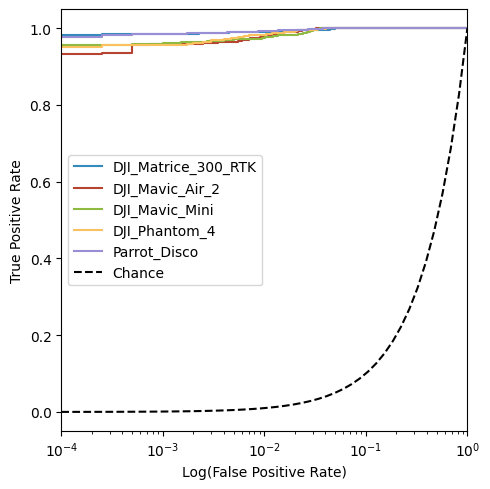

confm=array([[980,   3,   5,   5,   7],
       [  0, 970,  15,  10,   5],
       [  0,  12, 974,  12,   2],
       [  0,  10,   5, 982,   3],
       [  0,   2,   8,   2, 988]])


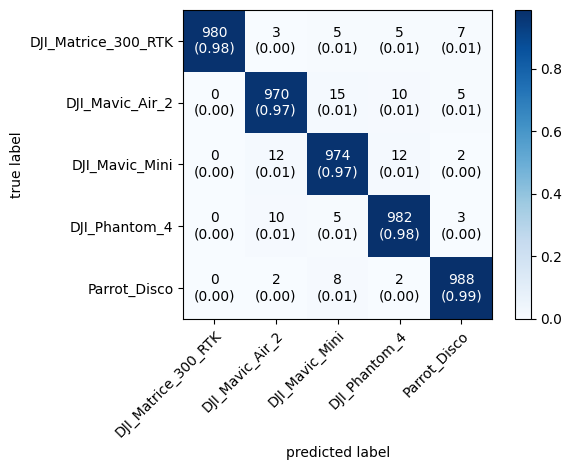

f1=tensor(0.9788)
SNR: 15 dB


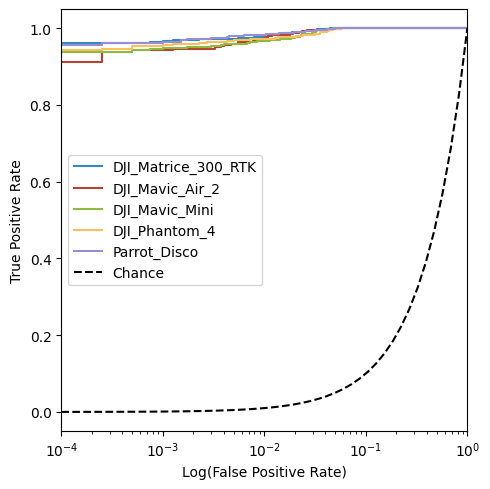

confm=array([[957,   6,   5,  10,  22],
       [  0, 967,   8,  19,   6],
       [  0,  13, 961,  17,   9],
       [  0,   7,  10, 976,   7],
       [  0,   2,   4,  11, 983]])


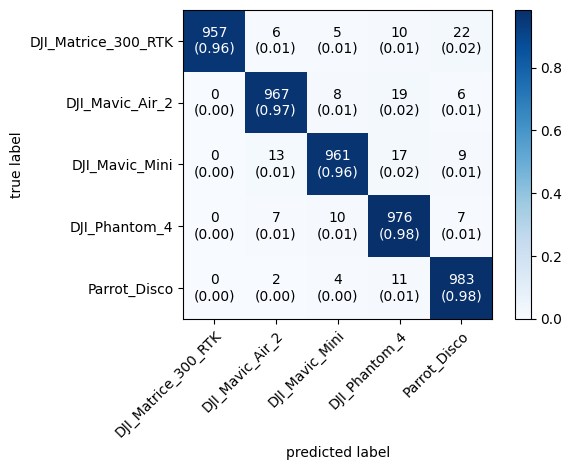

f1=tensor(0.9688)
SNR: 10 dB


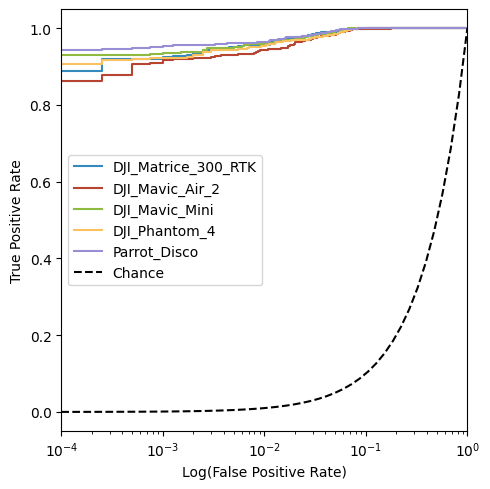

confm=array([[936,  15,   2,  13,  34],
       [  3, 948,  11,  22,  16],
       [  3,  12, 950,  22,  13],
       [  4,  10,   9, 967,  10],
       [  2,   4,   9,   9, 976]])


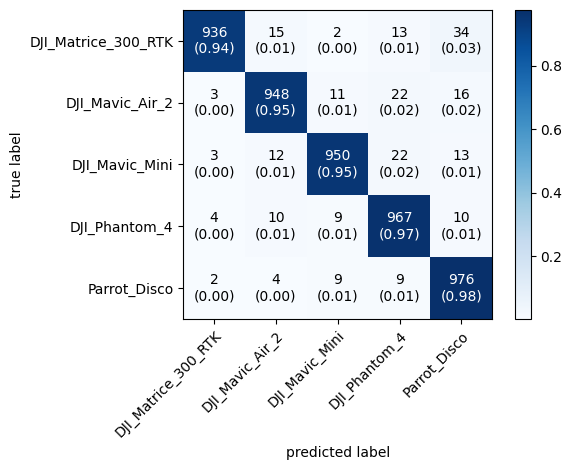

f1=tensor(0.9554)
SNR: 5 dB


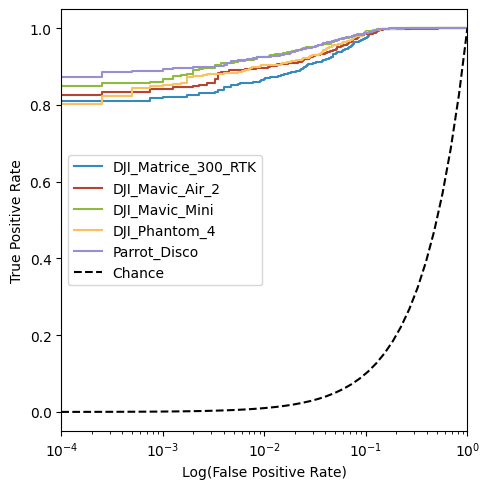

confm=array([[855,  31,  11,  58,  45],
       [ 14, 908,   6,  38,  34],
       [  8,  16, 919,  30,  27],
       [  6,  26,   7, 940,  21],
       [  8,  12,  10,  18, 952]])


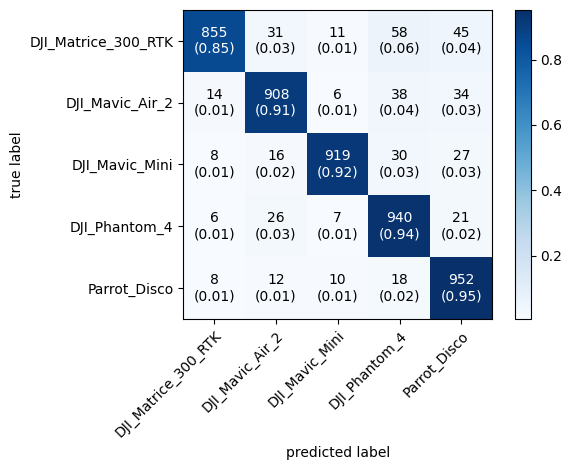

f1=tensor(0.9148)
SNR: 0 dB


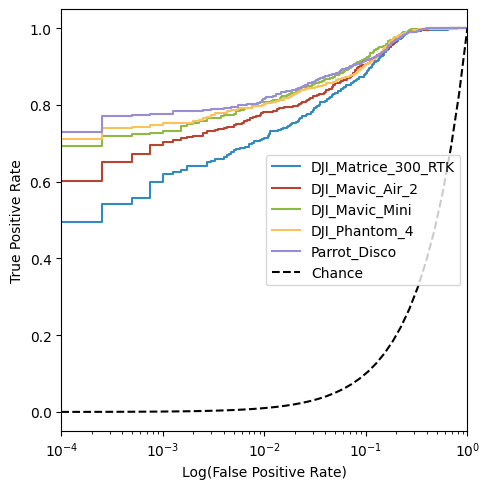

confm=array([[749,  66,  15, 110,  60],
       [ 28, 826,  15, 101,  30],
       [ 21,  40, 823,  81,  35],
       [ 12,  33,  23, 899,  33],
       [ 23,  27,  19,  63, 868]])


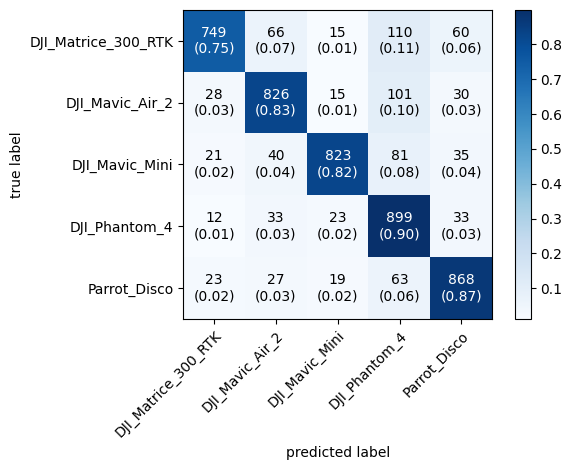

f1=tensor(0.8330)
SNR: -5 dB


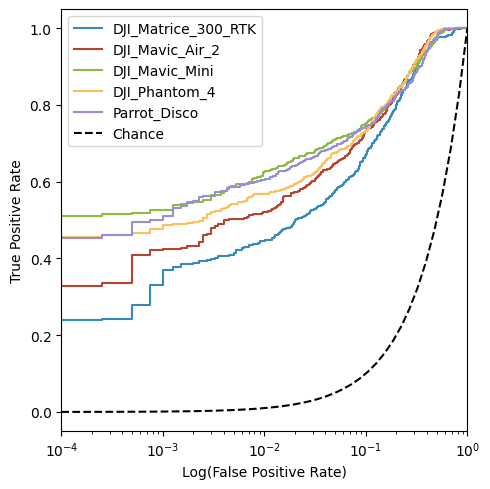

confm=array([[538, 147,  43, 204,  68],
       [ 36, 706,  29, 187,  42],
       [ 31,  72, 685, 162,  50],
       [ 31,  84,  22, 825,  38],
       [ 44,  63,  54, 162, 677]])


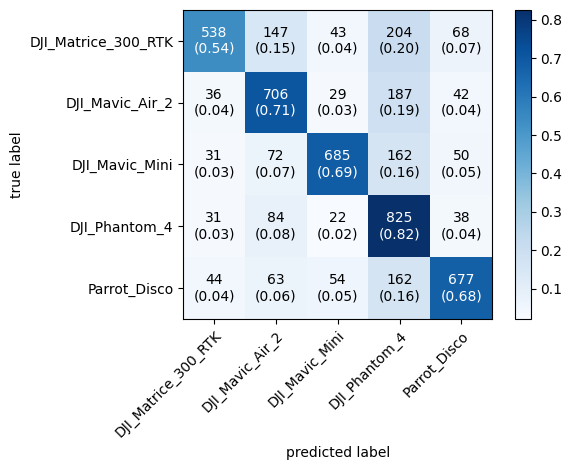

f1=tensor(0.6862)


In [ ]:
model_snr = 5
for snr in [20, 15, 10, 5, 0, -5]:
    conf = {}
    conf['f_s'] = 10_000
    conf['SNR'] = snr
    conf['batch_size'] = 8
    conf['epochs'] = 10
    conf['learning_rate'] = 0.001
    conf['plot_confusion'] = True
    conf['model_path'] = f"{model_path}/hybrid-parallel-model-{model_snr}.pt"

    testset_root = f"{radar_path}/{data_dir}/testset/{conf['f_s']}fs/{conf['SNR']}SNR"
    testds = ds.DatasetFolder( testset_root, dataloader, extensions=("npy",))
    testLoader = torch.utils.data.DataLoader( testds, conf["batch_size"], shuffle=True, num_workers=2)

    print(f"SNR: {snr} dB")
    test(conf, testLoader, device)

### Generate Plots from Model Evaluation Results

Model evaluation for SNR=20
Model evaluation for SNR=15
Model evaluation for SNR=10
Model evaluation for SNR=5
Model evaluation for SNR=0
Model evaluation for SNR=-5



F1 Scores for Model Trained with SNR=5

Signal SNR      F1 Score
------------------------
   20   :     0.979
   15   :     0.969
   10   :     0.955
   5    :     0.915
   0    :     0.833
   -5   :     0.686





/tmp/ipykernel_1729675/2716657634.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/tmp/ipykernel_1729675/2716657634.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


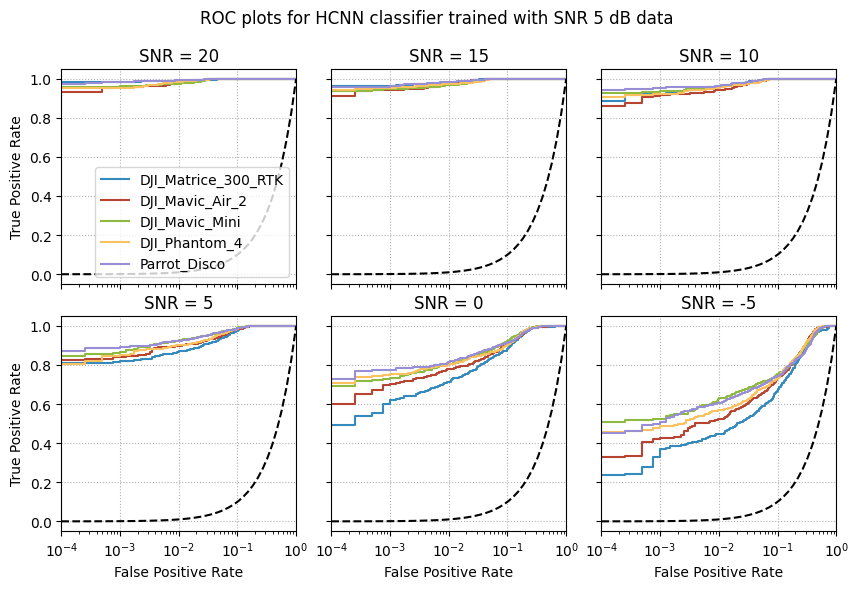

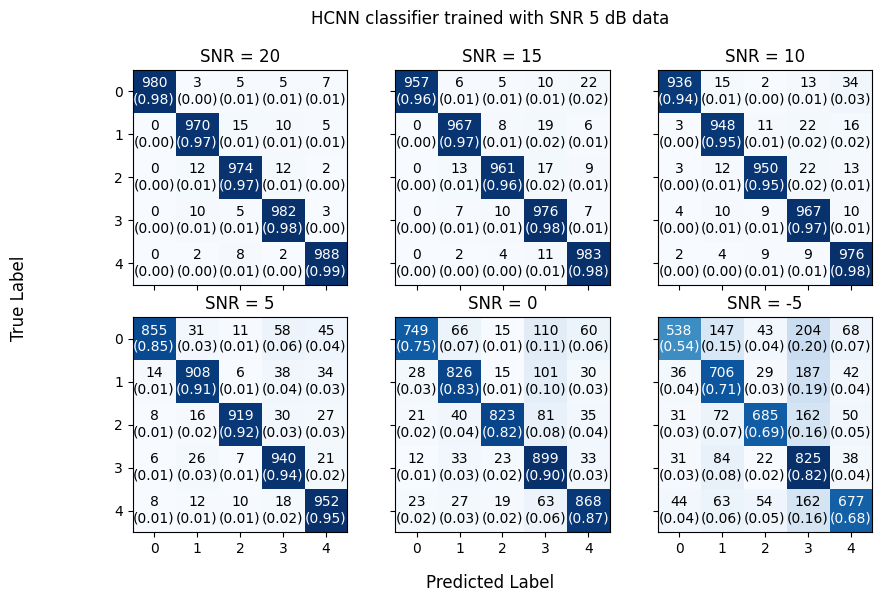

In [ ]:
from itertools import cycle

def evaluate_model(model, loader):
    target = None
    probabilities = None
    predicted = None
    testloss = 0

    for i, data in enumerate(loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        if target is None:
            target = labels
        else:
            target = torch.cat((target, labels))

        outputs = model(inputs.float())
        loss = loss_fn(outputs, labels)
        testloss += loss.item()

        partial_probabilities = nn.Softmax(dim=1)(outputs.data)
        if probabilities is None:
            probabilities = partial_probabilities
        else:
            probabilities = torch.cat((probabilities, partial_probabilities))

        _, partial_predicted = torch.max(outputs.data, 1)

        if predicted is None:
            predicted = partial_predicted
        else:
            predicted = torch.cat((predicted, partial_predicted))
    return target, predicted, probabilities


def calc_model_f1_scores(pred, real):
    f1_scores = {}
    for idx, snr in enumerate(test_snrs):
        f1_scores[snr] = float(multiclass_f1_score(pred[idx], real[idx], num_classes=5, average='micro').numpy())
    return f1_scores


def print_f1_scores(mdl_snr, pred, real):
    f1_scores = calc_model_f1_scores(pred, real)

    print("\n\n")
    print(f"F1 Scores for Model Trained with SNR={mdl_snr}\n")
    print("Signal SNR      F1 Score")
    print("------------------------")
    for snr, f1 in f1_scores.items():
        print(f"{snr:^8}:     {f1:.3f}")
    print("\n\n")


def plot_confusion_matrices(mdl_snr, snrs, pred, real):
    fig = plt.figure(figsize=(10, 6))
    gs = fig.add_gridspec(nrows=2, ncols=3, hspace=0.15, wspace=0.05)
    axs = gs.subplots(sharex='col', sharey='row')
    for idx, snr in enumerate(confusion_snrs):
        col = idx % 3
        row = idx // 3
        confm = confusion_matrix(target[idx], predicted[idx])
        plot_confusion_matrix(conf_mat=confm,
                              figure=fig,
                              axis=axs[row, col],
                              show_normed=True,
                              colorbar=False)
        axs[row, col].set_title(f"SNR = {snr}")
        axs[row, col].label_outer()
    axs[1,2].set_xlabel("")
    axs[1,2].set_ylabel("")
    fig.supxlabel("Predicted Label")
    fig.supylabel("True Label")
    fig.suptitle(f"HCNN classifier trained with SNR {mdl_snr} dB data")
    plt.tight_layout()
    plt.savefig(f"{plot_path}/hybrid_classifier_confusion_snr_{mdl_snr}.eps")


def plot_roc_plots(mdl_snr, targets, probs, remove_zeros=False, semilog_axes=True):
    fig = plt.figure(figsize=(10, 6))
    gs = fig.add_gridspec(nrows=2, ncols=3, hspace=0.15, wspace=0.15)
    axs = gs.subplots(sharex='col', sharey='row')
    colors = cycle(['#348ABD', '#b74331', '#8EBA42', '#FBC15E', '#988ED5'])
    for idx, (snr, real, probability) in enumerate(zip(test_snrs, targets.values(), probs.values())):
        col = idx % 3
        row = idx // 3
        ax = axs[row, col]
        lb = LabelBinarizer().fit(real)
        one_hot_target = lb.transform(real)
        for class_id, color in zip(range(5), colors):
            fpr, tpr, _ = roc_curve(one_hot_target[:,class_id], probability[:,class_id])
            if remove_zeros is True:
                zero_indices = np.where(np.isclose(fpr, 0))
                fpr = np.delete(fpr, zero_indices)
                tpr = np.delete(tpr, zero_indices)
            else:
                fpr[np.isclose(fpr,0)] = 1e-10
            display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(
                name=f"{drone_type_map[class_id]}",
                ax=ax,
                color=color)
        if semilog_axes is True:
            display.ax_.set_xscale("log")
            display.ax_.set_xlim(roc_curve_minimum, 1.0)
        display.ax_.set_xlabel("False Positive Rate")
        display.ax_.set_ylabel("True Positive Rate")
        display.ax_.set_title(f"SNR = {snr}")
        display.ax_.grid(linestyle=':')
        line = display.ax_.plot(np.geomspace(roc_curve_minimum,1.0), np.geomspace(roc_curve_minimum,1.0),
                                color='k', linestyle="dashed", label="Chance")
        display.ax_.label_outer()
        if idx != 0:
            display.ax_.get_legend().remove()
    fig.suptitle(f"ROC plots for HCNN classifier trained with SNR {mdl_snr} dB data")
    plt.tight_layout()
    plt.savefig(f"{plot_path}/hybrid_detector_roc_plots_snr_{mdl_snr}.eps")

# ---------- Run model evaluations and save results

model_snr = 5
test_snrs = [20, 15, 10, 5, 0, -5]

target = {}
predicted = {}
probabilities = {}

for idx, snr in enumerate(test_snrs):
    conf = {}
    conf['f_s'] = 10_000
    conf['SNR'] = snr
    conf['batch_size'] = 8
    conf['epochs'] = 10
    conf['learning_rate'] = 0.0005
    conf['plot_confusion'] = True
    conf['model_path'] = f"{model_path}/hybrid-parallel-model-{model_snr}.pt"

    testset_root = f"{radar_path}/{data_dir}/testset/{conf['f_s']}fs/{conf['SNR']}SNR"
    testds = ds.DatasetFolder( testset_root, dataloader, extensions=("npy",))
    testLoader = torch.utils.data.DataLoader( testds, conf["batch_size"], shuffle=True, num_workers=2)

    net = HybridRadarClassifier(conf).to(device)
    net.load_state_dict(torch.load(conf['model_path']))
    net.eval()

    correct = 0
    total = 0
    testloss = 0
    loss_fn = nn.CrossEntropyLoss().to(device)
    confm = np.zeros((2, 2), dtype=int)

    print(f"Model evaluation for SNR={snr}")
    target[idx], predicted[idx], probabilities[idx] = evaluate_model(net, testLoader)

# ---------- F1 scores


print_f1_scores(model_snr, predicted, target)


# ---------- ROC plots


plot_roc_plots(model_snr, target, probabilities)


# ---------- Confusion matrices

# Note: If the number of entries in this list is changed then the plot
# code in plot_confusion_matrices will need to be updated.
confusion_snrs = [20, 15, 10, 5, 0, -5]

plot_confusion_matrices(model_snr, confusion_snrs, predicted, target)


### Generate Plot of SNR Against F1 Score

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


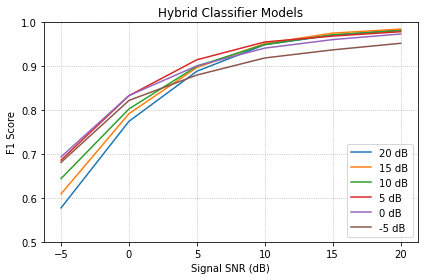

In [ ]:
model_snrs = [20, 15, 10, 5, 0, -5]
test_snrs = [20, 15, 10, 5, 0, -5]


f1_scores = {}
for model_snr in model_snrs:
    target = {}
    predicted = {}
    probabilities = {}

    for idx, snr in enumerate(test_snrs):
        conf = {}
        conf['f_s'] = 10_000
        conf['SNR'] = snr
        conf['batch_size'] = 8
        conf['epochs'] = 10
        conf['learning_rate'] = 0.0005
        conf['plot_confusion'] = True
        conf['model_path'] = f"{model_path}/hybrid-parallel-model-{model_snr}.pt"

        testset_root = f"{radar_path}/{data_dir}/testset/{conf['f_s']}fs/{conf['SNR']}SNR"
        testds = ds.DatasetFolder( testset_root, dataloader, extensions=("npy",))
        testLoader = torch.utils.data.DataLoader( testds, conf["batch_size"], shuffle=True, num_workers=2)

        net = HybridRadarClassifier(conf).to(device)
        net.load_state_dict(torch.load(conf['model_path']))
        net.eval()

        correct = 0
        total = 0
        testloss = 0
        loss_fn = nn.CrossEntropyLoss().to(device)
        confm = np.zeros((2, 2), dtype=int)

        target[idx], predicted[idx], probabilities[idx] = evaluate_model(net, testLoader)

    f1_scores[model_snr] = calc_model_f1_scores(predicted, target)


fig = plt.figure(figsize=(6.0, 4.0), dpi=72)
ax = fig.add_subplot(111)
ax.grid(linestyle=':')
ax.grid(which='both', axis='x', linestyle=':')
_ = ax.set_ylim([0.5, 1.0])
ax.set_title("Hybrid Classifier Models")
ax.set_xlabel("Signal SNR (dB)")
ax.set_ylabel("F1 Score")
for model_snr, snr_dict in f1_scores.items():
    _ = ax.plot(snr_dict.keys(), snr_dict.values(), label=f"{model_snr} dB")
_ = ax.legend()
fig.tight_layout()
plt.savefig(f"{plot_path}/hybrid_classifier_f1_scores.eps")


### Generate an Ensemble of Model Evaluations

In [ ]:
import json

data_dir = "test_sets/two_sided"
model_snr = 5
test_snrs = [20, 15, 10, 5, 0, -5]
test_datasets = ["testset_0", "testset_1", "testset_2", "testset_3", "testset_4"]

print(f"Calculating F1 score ensemble for model SNR = {model_snr}")

f1_scores = {}
for test_dataset in test_datasets:
    target = {}
    predicted = {}
    probabilities = {}

    print(f"  Calculating F1 scores for testset = '{test_dataset}'")

    for idx, snr in enumerate(test_snrs):
        conf = {}
        conf['f_s'] = 10_000
        conf['SNR'] = snr
        conf['batch_size'] = 8
        conf['epochs'] = 10
        conf['learning_rate'] = 0.0005
        conf['plot_confusion'] = True
        conf['model_path'] = f"{model_path}/hybrid-parallel-model-{model_snr}.pt"

        #print(f"    Calculating F1 scores for signal SNR = {snr}")
        testset_root = f"{radar_path}/{data_dir}/{test_dataset}/{conf['f_s']}fs/{conf['SNR']}SNR"
        testds = ds.DatasetFolder( testset_root, dataloader, extensions=("npy",))
        testLoader = torch.utils.data.DataLoader( testds, conf["batch_size"], shuffle=True, num_workers=2)

        net = HybridRadarClassifier(conf).to(device)
        net.load_state_dict(torch.load(conf['model_path']))
        net.eval()

        correct = 0
        total = 0
        testloss = 0
        loss_fn = nn.CrossEntropyLoss().to(device)
        confm = np.zeros((2, 2), dtype=int)

        target[idx], predicted[idx], probabilities[idx] = evaluate_model(net, testLoader)

    f1_scores[test_dataset] = calc_model_f1_scores(predicted, target)

f1_scores_file = f"{plot_path}/hybrid_model_snr{model_snr}_ensemble_f1_scores.json"
with open(f1_scores_file, 'w') as fd:
    json.dump(f1_scores, fd)

snr_list = [[snr for snr in d.keys()] for d in f1_scores.values()][0]
f1_arrays = [np.array(l) for l in [[d[snr] for d in f1_scores.values()] for snr in snr_list]]
f1_means = [np.mean(f1_array) for f1_array in f1_arrays]
f1_stddevs = [np.std(f1_array) for f1_array in f1_arrays]

print("\n\n")
print(f"  Hybrid Classifier for {model_snr}dB")
print("  SNR   Mean F1  F1 Std. dev.")
print("-----------------------------")
for i, snr in enumerate(snr_list):
    print(f"{snr:>5}: {f1_means[i]:7.3f}  {f1_stddevs[i]:9.6f}")
